In [1]:
from indigo import Indigo
import numpy as np
import pandas as pd
import asyncio
import shutil

from pathlib import Path
import sys

packages_dir = Path.cwd().absolute().parent / 'python' / 'packages'
assert packages_dir.is_dir()
sys.path.append(str(packages_dir))

from substructure_finder import BucketsInitializer
from substructure_finder.search_engines import ProcessPoolSearchEngine, RamProcessPoolSearchEngine
from substructure_finder import DbFilesystem

import fp_utils
from fp_utils.finders import Finder
from fp_utils.testing import FinderSpeedTester
from fp_utils.catch_time import CatchTime

fp_utils.settings.init_fp_utils()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
base_drives_dir = Path('../data/drives/')
other_dir = Path('../data/drives/0/')
drives_number = 4
zero_columns_name = '../data/zero_columns'
db_name = 'db_500k'

data_dirs = [base_drives_dir / str(i) for i in range(1, drives_number + 1)]
db_fs = DbFilesystem(data_dirs, other_dir)

Path(zero_columns_name).exists(), \
all(map(lambda x: (x / db_name).is_dir(), data_dirs)), \
(other_dir / db_name).is_dir()

(True, True, True)

# Search Queries

In [3]:
with open(zero_columns_name, 'r') as f:
    zero_columns = list(map(int, f.read().split()))
assert list(sorted(zero_columns)) == zero_columns

full_columns = list(sorted(set(range(3736)) - set(zero_columns)))

def bin_format(number, num_of_bits=3736):
    fp = list(map(int, list(bin(int(number, 16))[2:].zfill(num_of_bits))))
    return np.fromiter(fp, dtype=int)

def smiles_to_fingerprint(smiles):
    indigo_mol_to_test = Indigo().loadMolecule(smiles)
    full_fp = bin_format(indigo_mol_to_test.fingerprint("sub").toString())
    return np.fromiter(pd.Series(full_fp)[full_columns].values, dtype=bool)

@CatchTime("search")
def search(smiles: str, finder: Finder, ans_count=None):
    fp = smiles_to_fingerprint(smiles)
    return list(finder.find(fp, ans_count))

### Finders init

In [4]:
class ProcessPoolFinder(ProcessPoolSearchEngine, Finder):
    def find_all(self, fp):
        return self.search(fp)

In [5]:
class RamProcessPoolFinder(RamProcessPoolSearchEngine, Finder):
    def find_all(self, fp):
        return self.search(fp)

In [6]:
# finder = ComplexFinder(db_fs, db_name)
# thread_pool_finder = ThreadPoolFinder(db_fs, db_name)
process_pool_finder = ProcessPoolFinder(db_fs, db_name)
ram_process_pool_finder = RamProcessPoolFinder(db_fs, db_name)

0.019s -- ProcessPoolFinder init time
6.716s -- RamProcessPoolFinder init time


### Queries init

In [7]:
with open('../data/pubchem_994_queries.txt', 'r') as f:
    queries = list(map(lambda x: x.split()[0], f.read().strip().split('\n')))
    
queries_fp = [smiles_to_fingerprint(smiles) for smiles in queries]

len(queries), queries[:5]

(157,
 ['Cc1c[n]c2[nH]ccc2c1Cl',
  'OC(=O)c1c[n]c2[nH]ccc2c1Cl',
  'Cc1c(Cl)c[n]c2[nH]ccc21',
  'Oc1c[n]c2[nH]ccc2c1Cl',
  'N[C@@H](C[S@](=O)CCO)C(O)=O'])

### Speed testing

In [12]:
speed_tester = FinderSpeedTester([process_pool_finder, ram_process_pool_finder])

In [ ]:
stat = speed_tester.test_all(queries_fp, ans_count=10, verbose=True)

-----
Test #000


Buckets number: 376


1.551 -- ProcessPoolFinder


Buckets number: 376


1.127 -- RamProcessPoolFinder
-----
Test #001


Buckets number: 231


1.024 -- ProcessPoolFinder


Buckets number: 231


0.722 -- RamProcessPoolFinder
-----
Test #002


Buckets number: 373


1.532 -- ProcessPoolFinder


Buckets number: 373


1.188 -- RamProcessPoolFinder
-----
Test #003


Buckets number: 376


1.705 -- ProcessPoolFinder


Buckets number: 376


1.130 -- RamProcessPoolFinder
-----
Test #004


Buckets number: 522


2.351 -- ProcessPoolFinder


Buckets number: 522


1.577 -- RamProcessPoolFinder
-----
Test #005


Buckets number: 151


0.953 -- ProcessPoolFinder


Buckets number: 151


0.752 -- RamProcessPoolFinder
-----
Test #006


Buckets number: 522


3.416 -- ProcessPoolFinder


Buckets number: 522


2.227 -- RamProcessPoolFinder
-----
Test #007


Buckets number: 469


2.980 -- ProcessPoolFinder


Buckets number: 469


1.929 -- RamProcessPoolFinder
-----
Test #008


Buckets number: 253


1.694 -- ProcessPoolFinder


Buckets number: 253


1.160 -- RamProcessPoolFinder
-----
Test #009


Buckets number: 772


0.384 -- ProcessPoolFinder


Buckets number: 772


0.717 -- RamProcessPoolFinder
-----
Test #010


Buckets number: 179


2.919 -- ProcessPoolFinder


Buckets number: 179


3.457 -- RamProcessPoolFinder
-----
Test #011


Buckets number: 772


0.379 -- ProcessPoolFinder


Buckets number: 772


0.943 -- RamProcessPoolFinder
-----
Test #012


Buckets number: 480


1.623 -- ProcessPoolFinder


Buckets number: 480


2.105 -- RamProcessPoolFinder
-----
Test #013


Buckets number: 139


3.708 -- ProcessPoolFinder


Buckets number: 139


3.440 -- RamProcessPoolFinder
-----
Test #014


Buckets number: 190


1.319 -- ProcessPoolFinder


Buckets number: 190


1.338 -- RamProcessPoolFinder
-----
Test #015


Buckets number: 196


1.253 -- ProcessPoolFinder


Buckets number: 196


1.720 -- RamProcessPoolFinder
-----
Test #016


Buckets number: 198


0.631 -- ProcessPoolFinder


Buckets number: 198


0.932 -- RamProcessPoolFinder
-----
Test #017


Buckets number: 378


4.448 -- ProcessPoolFinder


Buckets number: 378


1.611 -- RamProcessPoolFinder
-----
Test #018


Buckets number: 139


0.877 -- ProcessPoolFinder


Buckets number: 139


0.709 -- RamProcessPoolFinder
-----
Test #019


Buckets number: 417


1.593 -- ProcessPoolFinder


Buckets number: 417


3.175 -- RamProcessPoolFinder
-----
Test #020


Buckets number: 354


1.359 -- ProcessPoolFinder


Buckets number: 354


2.211 -- RamProcessPoolFinder
-----
Test #021


Buckets number: 327


2.088 -- ProcessPoolFinder


Buckets number: 327


1.627 -- RamProcessPoolFinder
-----
Test #022


Buckets number: 478


1.827 -- ProcessPoolFinder


Buckets number: 478


2.311 -- RamProcessPoolFinder
-----
Test #023


Buckets number: 348


2.606 -- ProcessPoolFinder


Buckets number: 348


1.959 -- RamProcessPoolFinder
-----
Test #024


Buckets number: 582


3.611 -- ProcessPoolFinder


Buckets number: 582


2.217 -- RamProcessPoolFinder
-----
Test #025


Buckets number: 294


1.547 -- ProcessPoolFinder


Buckets number: 294


1.390 -- RamProcessPoolFinder
-----
Test #026


Buckets number: 378


2.733 -- ProcessPoolFinder


Buckets number: 378


1.589 -- RamProcessPoolFinder
-----
Test #027


Buckets number: 181


0.851 -- ProcessPoolFinder


Buckets number: 181


0.927 -- RamProcessPoolFinder
-----
Test #028


Buckets number: 172


1.324 -- ProcessPoolFinder


Buckets number: 172


0.894 -- RamProcessPoolFinder
-----
Test #029


Buckets number: 334


2.294 -- ProcessPoolFinder


Buckets number: 334


1.382 -- RamProcessPoolFinder
-----
Test #030


Buckets number: 177


1.229 -- ProcessPoolFinder


Buckets number: 177


0.813 -- RamProcessPoolFinder
-----
Test #031


Buckets number: 328


2.156 -- ProcessPoolFinder


Buckets number: 328


1.463 -- RamProcessPoolFinder
-----
Test #032


Buckets number: 165


0.958 -- ProcessPoolFinder


Buckets number: 165


0.902 -- RamProcessPoolFinder
-----
Test #033


Buckets number: 146


0.882 -- ProcessPoolFinder


Buckets number: 146


0.864 -- RamProcessPoolFinder
-----
Test #034


Buckets number: 182


1.546 -- ProcessPoolFinder


Buckets number: 182


0.949 -- RamProcessPoolFinder
-----
Test #035


Buckets number: 201


1.515 -- ProcessPoolFinder


Buckets number: 201


0.927 -- RamProcessPoolFinder
-----
Test #036


Buckets number: 184


0.291 -- ProcessPoolFinder


Buckets number: 184


0.639 -- RamProcessPoolFinder
-----
Test #037


Buckets number: 207


0.798 -- ProcessPoolFinder


Buckets number: 207


0.951 -- RamProcessPoolFinder
-----
Test #038


Buckets number: 277


0.818 -- ProcessPoolFinder


Buckets number: 277


1.108 -- RamProcessPoolFinder
-----
Test #039


Buckets number: 139


In [11]:
stat

ProcessPoolFinder:
	0.182 -- min
	21.737 -- max
	3.635 -- mean
	2.653 -- median

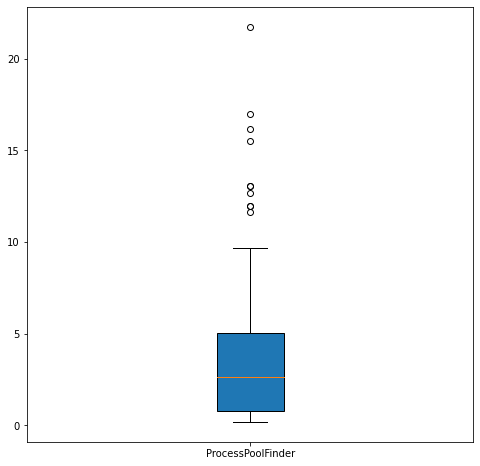

In [12]:
stat.as_boxplot()

### Draw answers

In [8]:
from fp_utils.draw import MoleculeDrawer

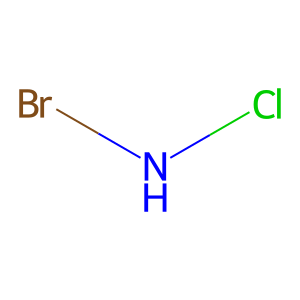

In [9]:
query = 'Br-N-Cl'
# query = queries[0]
MoleculeDrawer.draw_one(query)

In [10]:
answers = search(query, ram_process_pool_finder, ans_count=10)
len(answers)

Buckets number: 900


2.281s -- search


2

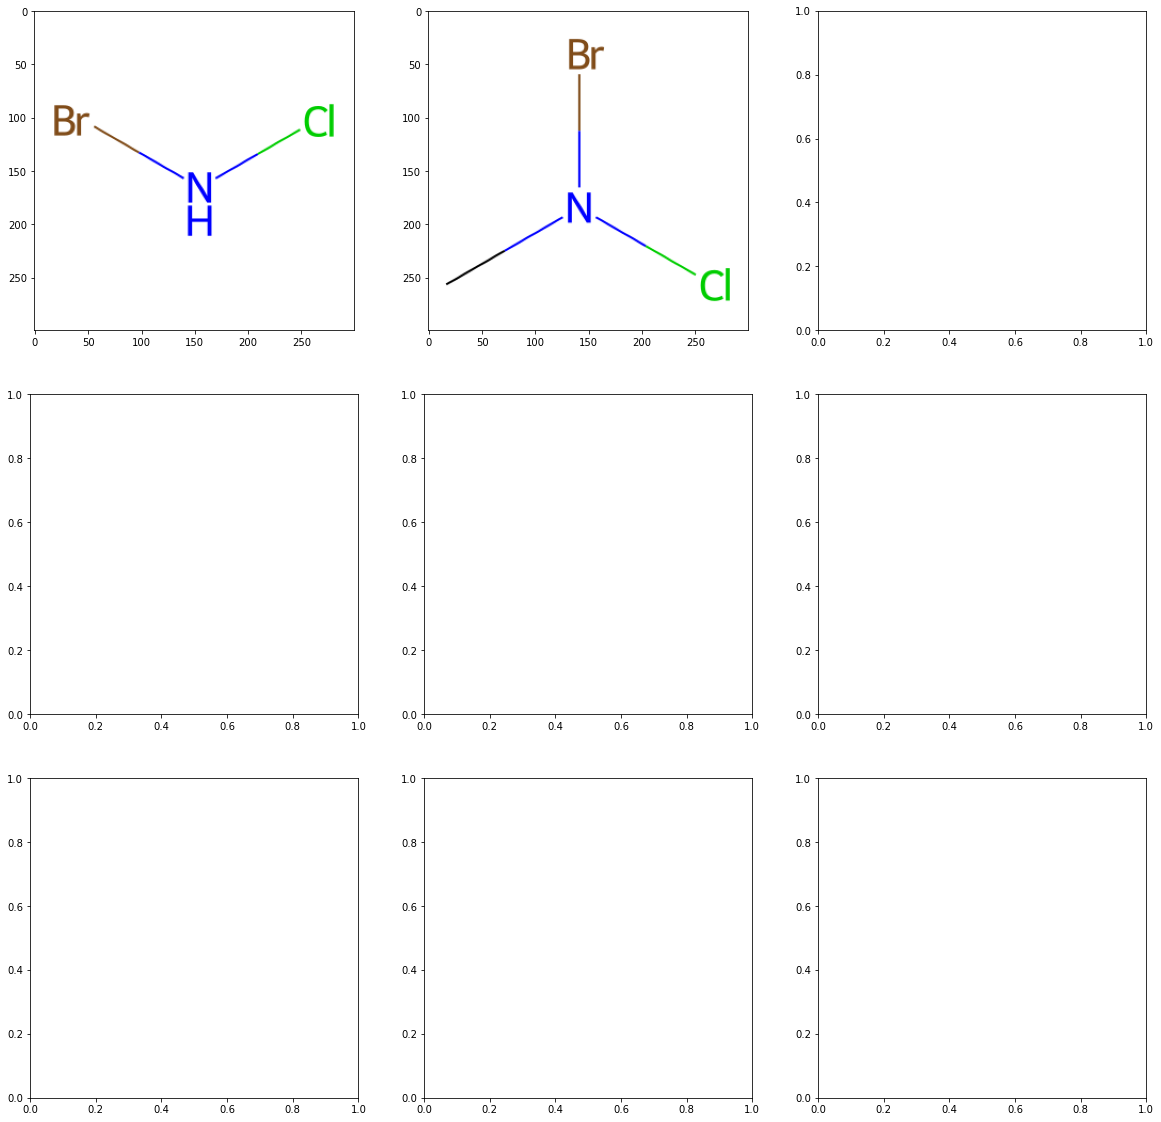

In [11]:
MoleculeDrawer.draw_many(answers, figsize=(20, 20), shape=(3, 3))